# <center>The Forecast of Google Index of "Python"</center>
<p style="text-align:right;">2019 数据轮子</p>

观测数据来自 Google trends: https://trends.google.com/trends/?geo=US

### 加载所需的包和模块

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt

%matplotlib inline
# 解决坐标轴刻度负号乱码
plt.rcParams['axes.unicode_minus'] = False
# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['Simhei']

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 6

import warnings
warnings.filterwarnings("ignore")

### 加载数据

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# dateparse('2015-01-04')

datetime.datetime(2015, 1, 4, 0, 0)

In [4]:
df = pd.read_csv('Google Index-Python Worldwide(2015.1-2018.8).csv', skiprows=3,
                 parse_dates=['Week'], index_col='Week', date_parser=dateparse,
                 names=['Week', 'Index'])

### 查看数据

In [5]:
# 查看前5条
df.head()

,Index
Week,
2015-01-04,43
2015-01-11,46
2015-01-18,47
2015-01-25,47
2015-02-01,50


In [6]:
min(df.index),max(df.index)

(Timestamp('2015-01-04 00:00:00'), Timestamp('2018-08-26 00:00:00'))

时间序列的观测时间间隔是周

### 生成时间序列

In [7]:
time_series = df['Index']

### 绘制时序图

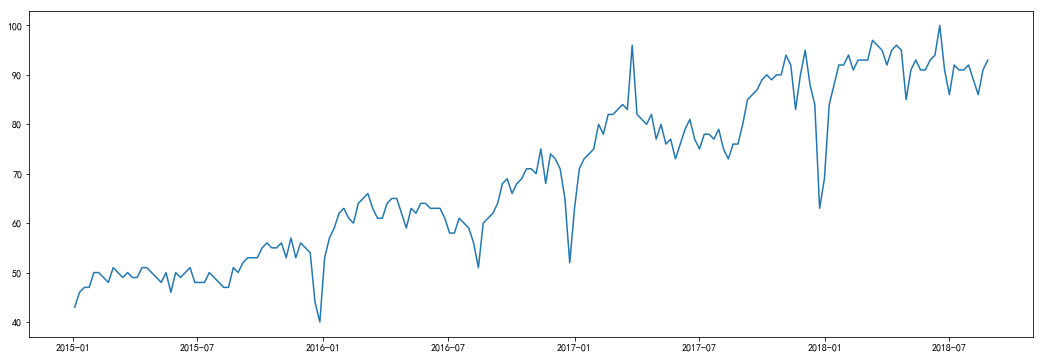

In [8]:
plt.plot(time_series);

从时序图上观测：数据非平稳，有上升的长期趋势，同时伴随季节性波动，季节性长度是52左右

### 将数据划分为训练集和测试集

In [9]:
# 将数据划分为训练集和测试集，测试集用于检验模型的拟合优度
train = time_series['2015':'2017']  # 取2015-2017三年观测为训练集
test = time_series['2018':]  # 取2018-01 - 2018-08 为测试集

min(train.index),max(train.index),min(test.index),max(test.index)

(Timestamp('2015-01-04 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-07 00:00:00'),
 Timestamp('2018-08-26 00:00:00'))

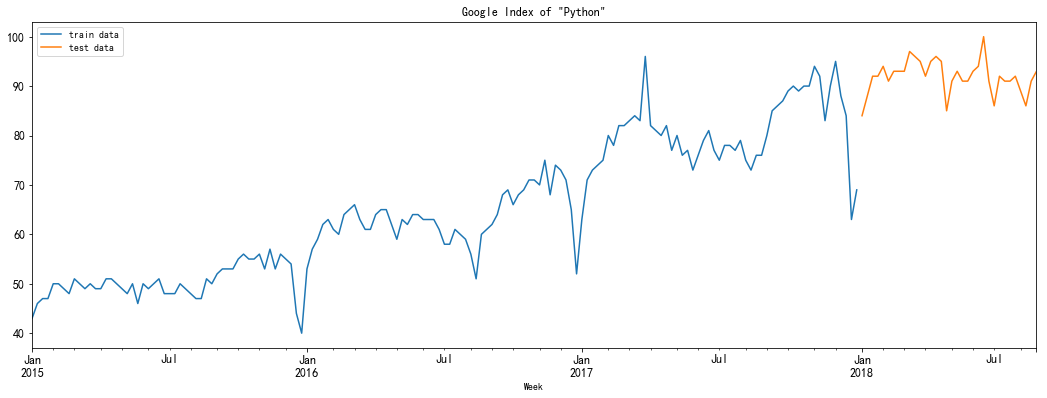

In [10]:
# 绘制时序图
train.plot(figsize=(18,6), title= 'Google Index of "Python"', label='train data', fontsize=12)
test.plot(figsize=(18,6), label='test data',fontsize=12)
plt.legend(loc='best')
plt.show()

## Holt-Winters Method

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt

In [12]:
y_hat_avg = test.copy()
fit_hw = ExponentialSmoothing(train, seasonal_periods=52,
                              trend='add', seasonal='add', freq='W'
                             ).fit()  # 加法模型

In [13]:
# fit_hw = ExponentialSmoothing(train, seasonal_periods=52,
#                               trend='mul', seasonal='mul', freq='W'
#                              ).fit()  # 乘法模型

In [14]:
# out-of-sample预测, 预测test部分
# y_hat_avg['Holt_Winter'] = fit_hw.forecast(len(test))

# in&out-of-sample 预测，预测train，test,之后的1年
y_hat_avg['Holt_Winters'] = fit_hw.predict(start='2015-01-04', end='2019-08-25')

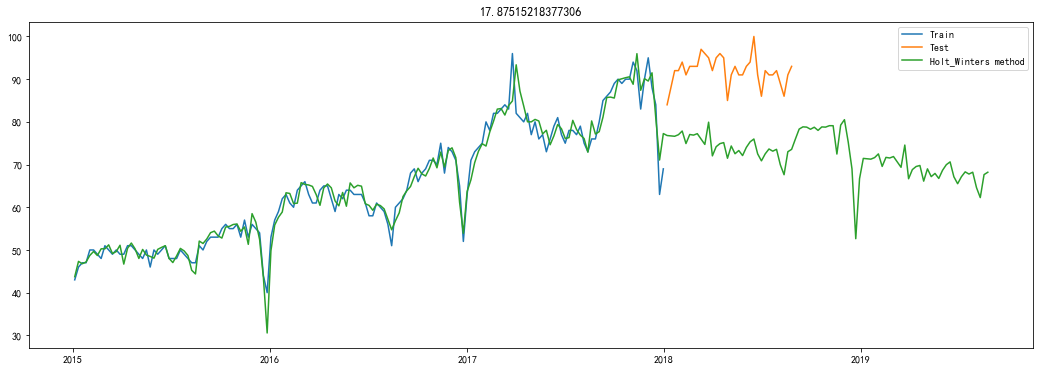

In [15]:
plt.figure(figsize=(18,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_avg['Holt_Winters'], label='Holt_Winters method')
plt.legend(loc='best')

pred_test = y_hat_avg['Holt_Winters']['2018-01':'2018-08']
rms = sqrt(mean_squared_error(test,pred_test))
plt.title(rms)
plt.show()

In [16]:
# 预测数据
y_hat_avg['Holt_Winters']['2018-09':]

2018-09-02    75.976315
2018-09-09    78.311465
2018-09-16    78.831482
2018-09-23    78.768484
2018-09-30    78.270932
2018-10-07    78.743907
2018-10-14    78.001977
2018-10-21    78.815870
2018-10-28    78.767223
2018-11-04    79.105170
2018-11-11    79.098797
2018-11-18    72.462886
2018-11-25    79.238948
2018-12-02    80.511853
2018-12-09    75.281342
2018-12-16    68.969273
2018-12-23    52.640331
2018-12-30    66.685358
2019-01-06    71.442399
2019-01-13    71.364180
2019-01-20    71.267823
2019-01-27    71.634134
2019-02-03    72.497720
2019-02-10    69.563108
2019-02-17    71.683409
2019-02-24    71.540685
2019-03-03    71.878905
2019-03-10    70.627276
2019-03-17    69.359091
2019-03-24    74.568349
2019-03-31    66.678445
2019-04-07    68.822034
2019-04-14    69.547118
2019-04-21    69.784112
2019-04-28    66.116683
2019-05-05    68.994504
2019-05-12    67.179191
2019-05-19    67.927122
2019-05-26    66.747339
2019-06-02    68.662131
2019-06-09    69.969502
2019-06-16    70

可以看到预测的指数会越来越小，偏离上升趋势，同时明显预测偏差过大；试试ARIMA模型

## SARIMAX 建模

In [17]:
ts = train

### 平稳性检验

In [18]:
from statsmodels.tsa.stattools import adfuller

# Dickey-Fuller Test
def test_stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

In [19]:
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.210443
p-value                          0.202477
#Lags Used                       0.000000
Number of Observations Used    156.000000
Critical Value (1%)             -3.472979
Critical Value (5%)             -2.880252
Critical Value (10%)            -2.576747
dtype: float64


p > 0.05 序列非平稳

### 平稳性处理

1. 对数变换

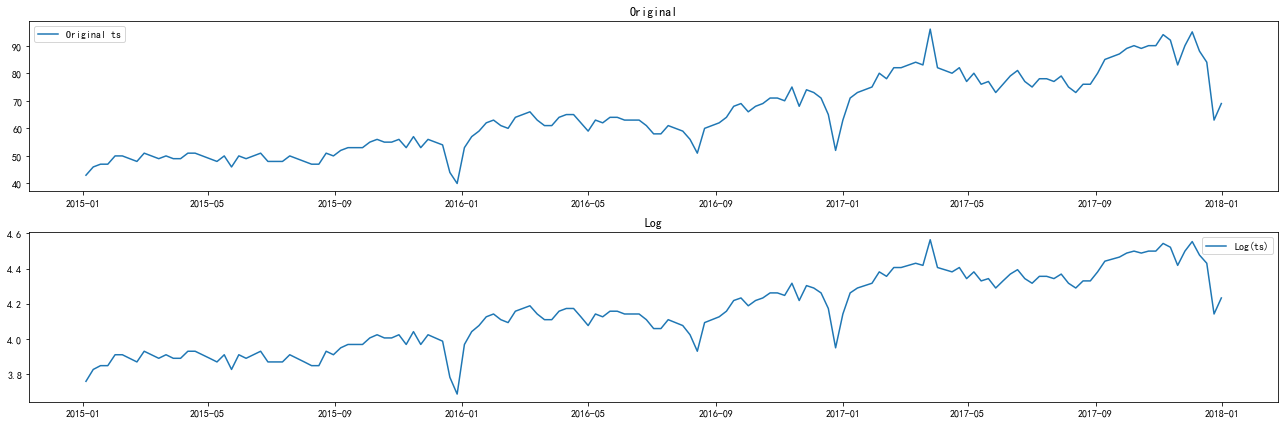

In [20]:
ts_log = np.log(ts)

plt.subplot(211)
plt.title('Original')
plt.plot(ts,label='Original ts')
plt.legend(loc='best')
plt.subplot(212)
plt.title('Log')
plt.plot(ts_log, label='Log(ts)')
plt.legend(loc='best')
plt.tight_layout()

2. 52步季节性差分

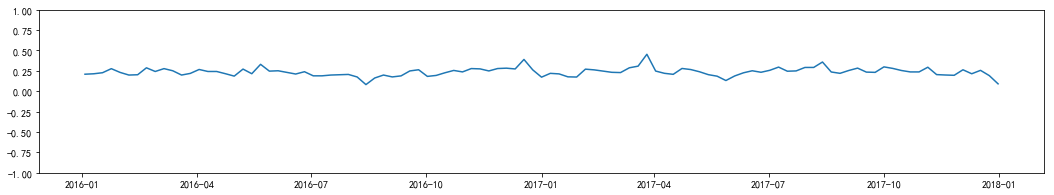

In [21]:
ts_log_diff = ts_log.diff(52)
plt.figure(figsize=(18,3))
plt.ylim(-1,1)
plt.plot(ts_log_diff);

In [22]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                -5.989286e+00
p-value                        1.761368e-07
#Lags Used                     0.000000e+00
Number of Observations Used    1.040000e+02
Critical Value (1%)           -3.494850e+00
Critical Value (5%)           -2.889758e+00
Critical Value (10%)          -2.581822e+00
dtype: float64


p < 0.05 可以说在95%的置信度下该序列平稳

### 模型拟合

#### ACF & PACF 图

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 自相关和偏相关图，默认为52阶
def draw_acf_pacf(ts, subtitle, lags=52):
    print("自相关图和偏相关图, max_lags={}".format(lags))
    f = plt.figure(facecolor='white', figsize=(18,4))
    ax1 = f.add_subplot(121)
    plot_acf(ts, lags=lags, ax=ax1, title='ACF\n{}'.format(subtitle))
    ax2 = f.add_subplot(122)
    plot_pacf(ts, lags=lags, ax=ax2, title='PACF\n{}'.format(subtitle))
    plt.show()

自相关图和偏相关图, max_lags=52


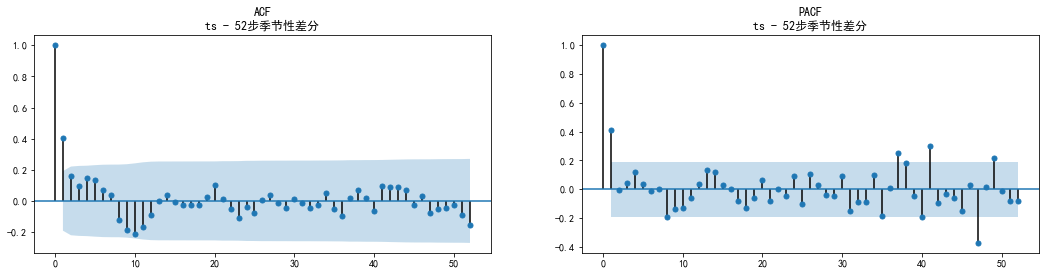

In [24]:
draw_acf_pacf(ts_log_diff, 'ts - 52步季节性差分', lags=52)

In [25]:
from statsmodels.tsa.arima_model import ARIMA

In [26]:
# fit ARIMA(1,0,1)
arima_1 = ARIMA(ts_log_diff, order=(1,0,1), freq='W').fit()  # p=1,q=1时，aic最小
print(arima_1.summary())

                              ARMA Model Results                              
Dep. Variable:                  Index   No. Observations:                  105
Model:                     ARMA(1, 1)   Log Likelihood                 173.980
Method:                       css-mle   S.D. of innovations              0.046
Date:                Thu, 01 Aug 2019   AIC                           -339.961
Time:                        23:23:40   BIC                           -329.345
Sample:                    01-03-2016   HQIC                          -335.659
                         - 12-31-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2355      0.008     29.962      0.000       0.220       0.251
ar.L1.Index     0.4107      0.220      1.868      0.065      -0.020       0.841
ma.L1.Index     0.0337      0.240      0.140    

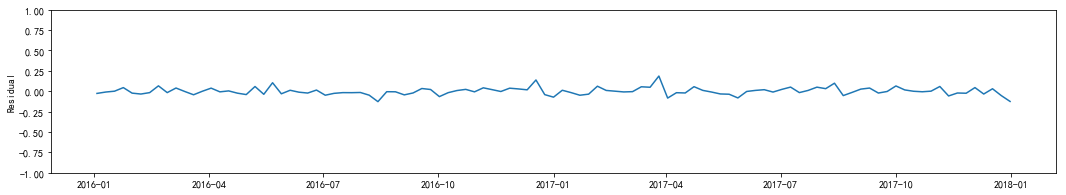

In [27]:
# 残差图
plt.figure(figsize=(18,3))
plt.ylim(-1,1)
plt.plot(arima_1.resid)
plt.ylabel('Residual');

### 残差诊断

自相关图和偏相关图, max_lags=52


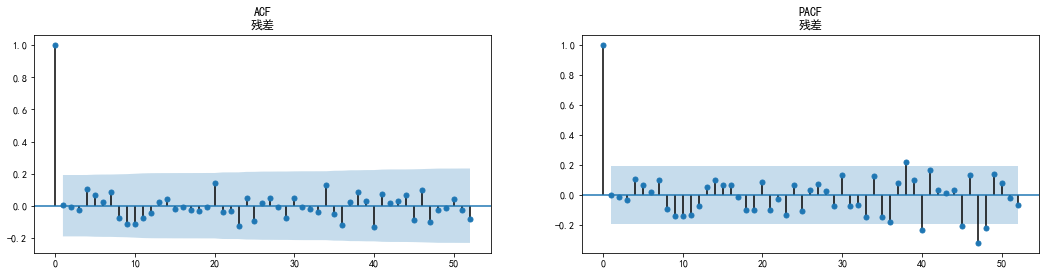

In [28]:
draw_acf_pacf(arima_1.resid, '残差', lags=52)

残差序列表现无相关性

In [29]:
# 白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox

# 白噪声检验：Ljung-Box test
def randomness(ts, lags=52):
    rdtest = acorr_ljungbox(ts,lags=lags)
    # 对上述函数求得的值进行语义描述
    rddata = np.c_[range(1,lags+1),rdtest[1:][0]]
    rdoutput = pd.DataFrame(rddata,columns=['lags','p-value'])
    return rdoutput.set_index('lags')

In [30]:
randomness(arima_1.resid, 7)

,p-value
lags,
1.0,0.975302
2.0,0.994850
3.0,0.991349
4.0,0.863319
5.0,0.883354
6.0,0.937559
7.0,0.919086


p-value > 0.05, 残差通过白噪声检验

In [31]:
min(ts_log_diff.index), max(ts_log_diff.index)

(Timestamp('2016-01-03 00:00:00'), Timestamp('2017-12-31 00:00:00'))

## **预测**
### Python中statsmodels里的ARIMA方法建模，预测数据为差分后的值，需要手动还原。可以利用ARIMA或ARMA训练参数后，改用SARIMAX方法进行建模并预测。

## SARIMAX

In [32]:
import statsmodels.tsa.api as smt

In [33]:
arima_final = smt.SARIMAX(ts_log, order=(1,0,1), seasonal_order=(0,1,0,52), freq='W').fit()
print(arima_final.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Index   No. Observations:                  157
Model:             SARIMAX(1, 0, 1)x(0, 1, 0, 52)   Log Likelihood                 165.363
Date:                            Thu, 01 Aug 2019   AIC                           -324.726
Time:                                    23:23:43   BIC                           -316.764
Sample:                                01-04-2015   HQIC                          -321.500
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9947      0.009    116.338      0.000       0.978       1.011
ma.L1         -0.5971      0.076   

模型诊断

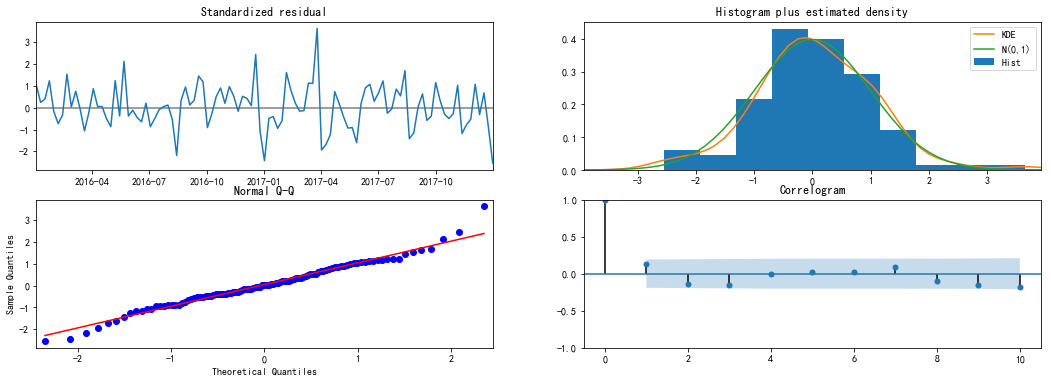

In [34]:
arima_final.plot_diagnostics();

残差通过白噪声检验

### 预测

In [35]:
# in&out-of-sample 预测，预测train，test,之后的1年
pred_in_out = arima_final.get_prediction(start='2015-01-04', end='2019-08-25',
                                         dynamic=False,full_results=False)

In [36]:
# 预测值，需要指数还原，因为建模序列是log变换后的
pred_mean = np.exp(pred_in_out.predicted_mean)

In [37]:
# pred_in_out.summary_frame()

In [38]:
# 置信区间
pred_ci = pred_in_out.conf_int()

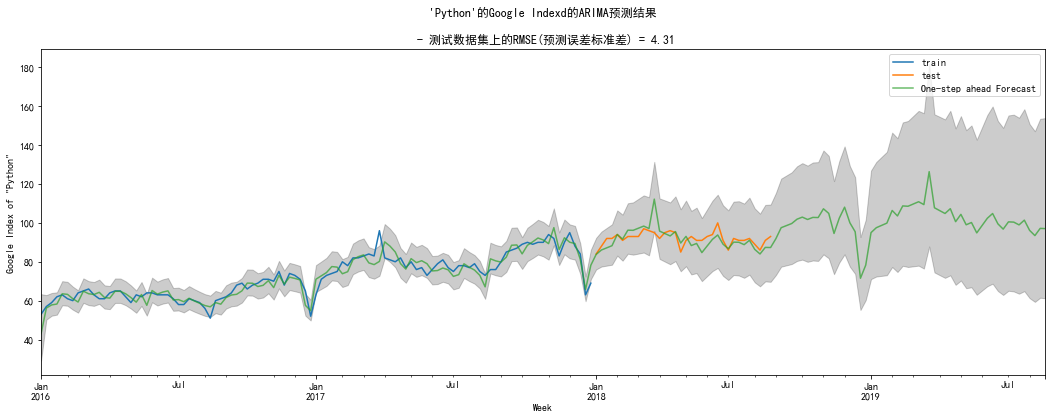

In [39]:
# 绘图
ax = ts['2016':].plot(label='train')
ax = test.plot(label='test')
pred_mean[52:].plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), color='k', alpha=.2)

ax.set_xlabel('Week')
ax.set_ylabel('Google Index of "Python"')

pred_test = pred_mean['2018-01':'2018-08']
rms = sqrt(mean_squared_error(test,pred_test))
ax.set_title("'Python'的Google Indexd的ARIMA预测结果\n\n - 测试数据集上的RMSE(预测误差标准差) = {:.2f}"
             .format(rms))
plt.legend(loc='best')
plt.show()

## 用全部数据训练模型

In [40]:
ts = time_series
ts_log = np.log(ts)

arima_final = smt.SARIMAX(ts_log, order=(1,0,1), seasonal_order=(0,1,0,52), freq='W').fit()
print(arima_final.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Index   No. Observations:                  191
Model:             SARIMAX(1, 0, 1)x(0, 1, 0, 52)   Log Likelihood                 224.857
Date:                            Thu, 01 Aug 2019   AIC                           -443.713
Time:                                    23:23:48   BIC                           -434.910
Sample:                                01-04-2015   HQIC                          -440.136
                                     - 08-26-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9960      0.007    141.228      0.000       0.982       1.010
ma.L1         -0.6169      0.066   

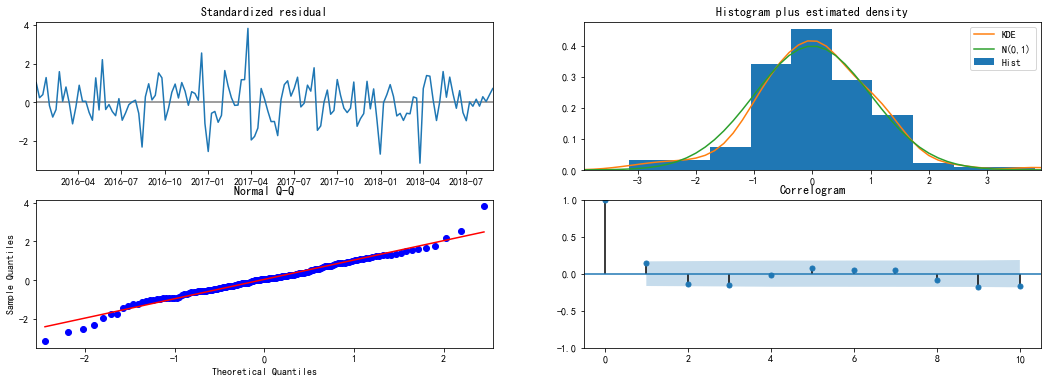

In [41]:
arima_final.plot_diagnostics();

### 预测

In [42]:
# in&out-of-sample 预测，预测train，test,之后的1年
pred_in_out = arima_final.get_prediction(start='2015-01-04',
                                         end='2019-08-25',
                                         dynamic=False,full_results=False)

In [43]:
# 预测值，需要指数还原，因为建模序列是log变换后的
pred_mean = np.exp(pred_in_out.predicted_mean)

In [44]:
min(ts.index), max(ts.index)

(Timestamp('2015-01-04 00:00:00'), Timestamp('2018-08-26 00:00:00'))

In [45]:
pred_mean[50:55]

2015-12-20     1.000007
2015-12-27     1.000007
2016-01-03    43.000323
2016-01-10    56.263638
2016-01-17    57.846702
Freq: W-SUN, dtype: float64

### 绘图

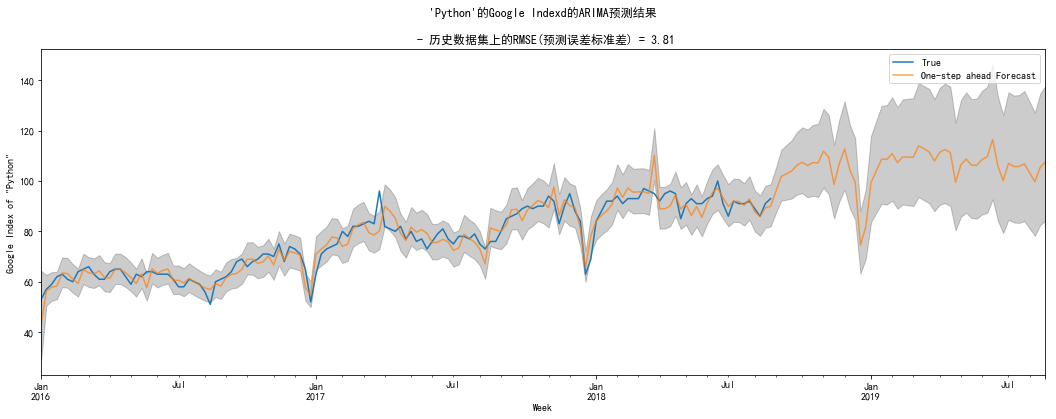

In [46]:
ax = ts[52:].plot(label='True')
pred_mean[52:].plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

# 置信区间
pred_ci = pred_in_out.conf_int()
ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), color='k', alpha=.2)

ax.set_xlabel('Week')
ax.set_ylabel('Google Index of "Python"')

rms = sqrt(mean_squared_error(ts[52:],pred_mean['2016-01-03':'2018-08-26']))
ax.set_title("'Python'的Google Indexd的ARIMA预测结果\n\n - 历史数据集上的RMSE(预测误差标准差) = {:.2f}"
             .format(rms))
plt.legend(loc='best')
plt.show()

In [47]:
# 之后的1年窗口预测
pred_1yr = pred_mean[-52:]

In [48]:
# 写出预测数据
pred_1yr.name = "Google Index of 'Python'"
pred_1yr.index.name = 'Week'
pred_1yr.to_csv("Google index-Worldwide(forecasting) - wuli.csv", header=True)